In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

from sklearn.cluster import KMeans

# Read in StringDB interaction data

In [2]:
#read in data and make a matrix of interactions
IA_data_start = pd.read_csv('Data/String_DB/9606.protein.links.v11.0.txt',  sep = ' ')
IA_df = pd.pivot_table(IA_data_start, index='protein1', columns='protein2', fill_value=0)
#Save it to disc:
IA_df.to_csv('Data/String_DB/IA_df.csv')

In [65]:
#Read in the interaction matrix
#IA_df = pd.read_csv('Data/String_DB/IA_df.csv')
predictions = pd.read_csv('Output/predictions.csv')
IA_df2 = IA_df.copy()
IA_df2.columns = list([x.split('.')[1] for x in IA_df2.index])
IA_df2.index = IA_df2.index.map(lambda x: x.split('.')[1])

In [68]:
#Map ENSP to Uniprot IDs
mapping_df = pd.read_csv('Data/Biogrid/uniprot_to_ensp.txt', sep = '\t')
mapping_dict = dict(zip(mapping_df['To'], mapping_df['From']))
mapping_dict_transformed = {key.split('.')[1]: value for key, value in mapping_dict.items()}

In [81]:
IA_df2 = IA_df2.rename(columns=mapping_dict_transformed)
IA_df2 = IA_df2.rename(index=mapping_dict_transformed)
#Remove proteins for which mapping to UniprotID cannot be performed:
IA_df3 = IA_df2[IA_df2.index.isin(predictions['Entry'])]
IA_df4 = IA_df3[IA_df3.columns[IA_df3.columns.isin(predictions['Entry'])]]

# Characterise the PPI distributions:

In [86]:
#Read in data:
data = pd.read_csv('Output/data_all.csv')
features = pd.read_csv('Data/Features/swissprot_features_and_predictions.csv')
RNA_binders = features['Entry'][features['RNA_binding'] == 1]
#Binaries the interaction matrix
IA_df4 = IA_df4.astype(int)
IA_df_binary = IA_df4 > 700
IA_counts_total = np.sum(IA_df_binary, axis = 0)

In [87]:
PPI_count_df = pd.DataFrame({'proteome_wide_interactors': IA_counts_total})
#Map which ones are in COND+ class:
COND_plus = data['Entry'][data['Enrichment'].notna()]
PPI_count_df['class'] = np.where(PPI_count_df.index.isin(COND_plus), 'COND+', 'COND-')

#Count interaction partners with COND+
IA_df_COND_plus = IA_df_binary[IA_df_binary.columns.isin(COND_plus)]
PPI_count_df['COND_plus_interactors'] = np.array(np.sum(IA_df_COND_plus, axis = 0))
#Count interaction partners with COND-
IA_df_COND_minus = IA_df_binary[IA_df_binary.columns.isin(COND_plus) == False]
PPI_count_df['COND_minus_interactors'] = np.array(np.sum(IA_df_COND_minus, axis = 0))
#and estimate fractions
PPI_count_df['proteome_interactors_frac'] = PPI_count_df['proteome_wide_interactors'] / PPI_count_df.shape[0] * 100
PPI_count_df['COND_plus_interactors_frac'] = PPI_count_df['COND_plus_interactors'] / PPI_count_df[PPI_count_df['class'] == 'COND+'].shape[0]* 100
PPI_count_df['COND_minus_interactors_frac'] = PPI_count_df['COND_minus_interactors'] / PPI_count_df[PPI_count_df['class'] == 'COND-'].shape[0]* 100


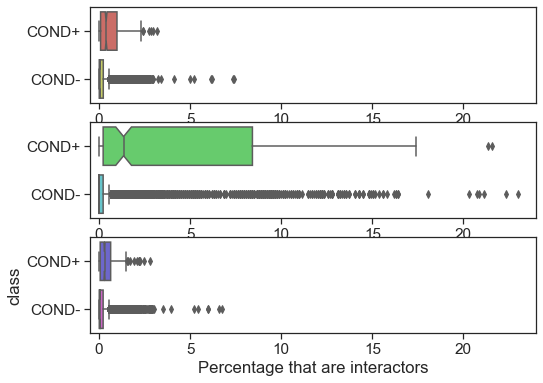

In [91]:
sns.set(style='white', font_scale=1.4)
sns.set_style('white', {'axes.linewidth': 0.5})
sns.set_style("ticks")

plt.rcParams['ytick.left'] = True
fig, ax = plt.subplots(3, 1, figsize=(8, 6))
palette_here = sns.color_palette("hls")

my_pal = {"COND+": palette_here[0], "COND-": palette_here[1]}
gfg = sns.boxplot(x = 'proteome_interactors_frac', y = 'class',  data = PPI_count_df, ax=ax[0],
                   notch=True, palette=my_pal, orient = 'h')
gfg.set_ylabel('')
TH1 = -0.5; TH2 = 24
gfg.set_xlim([TH1, TH2])
my_pal = {"COND+": palette_here[2], "COND-": palette_here[3]}
gfg = sns.boxplot(x = 'COND_plus_interactors_frac', y = 'class', data = PPI_count_df,
                   notch=True, ax=ax[1], palette=my_pal,  orient = 'h')
gfg.set_xlim([TH1, TH2])
gfg.set_xlabel('')
gfg.set_ylabel('')
my_pal = {"COND+": palette_here[4], "COND-": palette_here[5]}
gfg = sns.boxplot(x = 'COND_minus_interactors_frac', y = 'class', data = PPI_count_df,
                   notch=True, ax=ax[2], palette=my_pal,  orient = 'h')
gfg.set_xlim([TH1, TH2])
gfg.set_xlabel('Percentage that are interactors')
plt.savefig('Plots/PPI_distributions.pdf')
plt.show()

# Cluster based on interaction data to probe role of protein-protein vs protein-RNA interactions

In [92]:
import umap.umap_ as umap

In [186]:
features = pd.read_excel('Data/Swissprot/human_swissprot.xlsx')
convert_dict = dict(zip(features['Entry'], features['Gene']))

In [187]:
#Correlation matrix based on interaction profiles and read it in:
df_corr = pd.read_csv('Data/String_DB/StringDB_correlation_matrix.csv')
df_corr = df_corr.rename(columns = {df_corr.columns[0]: 'protein_ID'})
df_corr = df_corr.set_index('protein_ID')

In [188]:
df_corr_U2OS = df_corr[df_corr.columns[df_corr.columns.isin(data['Entry'])]]
df_corr_U2OS = df_corr_U2OS[df_corr_U2OS.index.isin(data['Entry'])]

In [189]:
#Project to 2D space:
umap_model = umap.UMAP(n_neighbors = 10, random_state=42)
umap_results1 = umap_model.fit_transform(df_corr_U2OS)

/opt/miniconda3/envs/etna/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


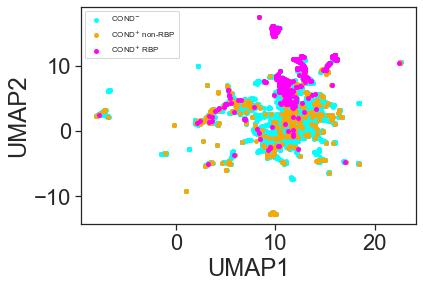

In [190]:
IA_UMAP = pd.DataFrame({'ID': df_corr_U2OS.index})
IA_UMAP['UMAP1'] = umap_results1[:,0]
IA_UMAP['UMAP2'] = umap_results1[:,1]
COND_plus = data['Entry'][data['Enrichment'].notna()]
COND_minus = data['Entry'][data['Enrichment'].isna()]
COND_plus_RNA = data['Entry'][(data['Enrichment'].notna()) & (data['Entry'].isin(RNA_binders))]

#Make plots of the 2D space that outlines each of the groups:
categories = [COND_minus, COND_plus, COND_plus_RNA]
colors = ['cyan', 'orange', 'magenta']
labels = ['COND$^{-}$', 'COND$^{+}$ non-RBP', 'COND$^{+}$ RBP']
for category, col, label in zip(categories, colors, labels):
    plt.scatter(IA_UMAP['UMAP1'][IA_UMAP['ID'].isin(category)], IA_UMAP['UMAP2'][IA_UMAP['ID'].isin(category)], 
                s = 15, color = col, marker = 'o', label = label)
plt.legend(fontsize = 8)
plt.xlabel('UMAP1'); plt.ylabel('UMAP2')
plt.savefig('Plots/protein_RNA_UMAP.png')

# GO-terms for clusters enriched in RBP and non-RBPs:

In [191]:
clusters = KMeans(n_clusters = 100, random_state=0).fit(IA_UMAP[['UMAP1', 'UMAP2']])
IA_UMAP['cluster_ID'] = np.array(clusters.labels_)
features = pd.read_csv('Data/Features/swissprot_features_and_predictions.csv')
RNA_binders = features['Entry'][features['RNA_binding'] == 1]

In [192]:
IA_UMAP['category'] = np.where(IA_UMAP['ID'].isin(categories[1]), 'COND+ non-RBP', np.NaN)
IA_UMAP['category'] = np.where(IA_UMAP['ID'].isin(categories[2]), 'COND+ RBP', IA_UMAP['category'])

In [193]:
fractions_nonRBP = []; fractions_RBP = []
for i in range(0, 100):
    df_cluster = IA_UMAP[IA_UMAP['cluster_ID'] == i]
    proteins_of_interest = len(df_cluster[df_cluster['category'] == 'COND+ non-RBP'])
    fractions_nonRBP.append(proteins_of_interest / len(df_cluster))
    proteins_of_interest = len(df_cluster[df_cluster['category'] == 'COND+ RBP'])
    fractions_RBP.append(proteins_of_interest / len(df_cluster))

RNA_fraction_df = pd.DataFrame({'cluster_ID': range(0, 100),
                                'fraction_COND_RNA_binders': fractions_RBP,
                               'fraction_COND_non_RNA_binders': fractions_nonRBP,})


In [194]:
import gseapy as gp

In [195]:
#Pink (RNA-mediated) clusters:
RNA_Cluster_IDs = RNA_fraction_df[RNA_fraction_df['fraction_COND_RNA_binders'] > 0.4]

IDs_cluster1 = IA_UMAP['ID'][IA_UMAP['cluster_ID'] == RNA_Cluster_IDs['cluster_ID'].iloc[0]]
enr = gp.enrichr(gene_list=IDs_cluster1.map(convert_dict), gene_sets=['GO_Molecular_Function_2021'], organism='Human')
df_enr = enr.results
df_enr1 = df_enr[df_enr['P-value'] < 0.01]

IDs_cluster2 = IA_UMAP['ID'][IA_UMAP['cluster_ID'] == RNA_Cluster_IDs['cluster_ID'].iloc[1]]
enr = gp.enrichr(gene_list=IDs_cluster2.map(convert_dict), gene_sets=['GO_Molecular_Function_2021'], organism='Human')
df_enr = enr.results
df_enr2 = df_enr[df_enr['P-value'] < 0.01]
df_enr2.head(8)

IDs_cluster3 = IA_UMAP['ID'][IA_UMAP['cluster_ID'] == RNA_Cluster_IDs['cluster_ID'].iloc[2]]
enr = gp.enrichr(gene_list=IDs_cluster3.map(convert_dict), gene_sets=['GO_Molecular_Function_2021'], organism='Human')
df_enr = enr.results
df_enr3 = df_enr[df_enr['P-value'] < 0.01]

Exception: Error getting the Enrichr libraries

In [ ]:
#Orange (non-RNA mediated clusters):
nonRNA_Cluster_IDs = RNA_fraction_df[RNA_fraction_df['fraction_COND_non_RNA_binders'] > 0.2]

IDs_cluster4 = IA_UMAP['ID'][IA_UMAP['cluster_ID'] == nonRNA_Cluster_IDs['cluster_ID'].iloc[0]]
enr = gp.enrichr(gene_list=IDs_cluster4.map(convert_dict), gene_sets=['GO_Molecular_Function_2021'], organism='Human')
df_enr = enr.results
df_enr4 = df_enr[df_enr['P-value'] < 0.01]

IDs_cluster5 = IA_UMAP['ID'][IA_UMAP['cluster_ID'] == nonRNA_Cluster_IDs['cluster_ID'].iloc[1]]
enr = gp.enrichr(gene_list=IDs_cluster5.map(convert_dict), gene_sets=['GO_Molecular_Function_2021'], organism='Human')
df_enr = enr.results
df_enr5 = df_enr[df_enr['P-value'] < 0.01]

IDs_cluster6 = IA_UMAP['ID'][IA_UMAP['cluster_ID'] == nonRNA_Cluster_IDs['cluster_ID'].iloc[3]]
enr = gp.enrichr(gene_list=IDs_cluster6.map(convert_dict), gene_sets=['GO_Molecular_Function_2021'], organism='Human')
df_enr = enr.results
df_enr6 = df_enr[df_enr['P-value'] < 0.01]

In [ ]:
#df_enr_comb = pd.concat([df_enr1, df_enr2, df_enr3])
#df_enr_comb.to_excel('Output/Cluster_enrichments_RBP.xlsx')
#df_enr_comb = pd.concat([df_enr4, df_enr5, df_enr6])
#df_enr_comb.to_excel('Output/Cluster_enrichments_nonRBP.xlsx')

# Evaluation - How do scores correlate with known condensate types?

In [106]:
import warnings
import itertools
warnings.filterwarnings("ignore", category=FutureWarning)

In [107]:
predictions = pd.read_csv('Output/predictions.csv')

5323


/var/folders/g8/bkvqzlv57q917j6d_31ky2sc0000gn/T/ipykernel_33326/2020254349.py:26: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(predictions[score_column][predictions[MLOs[m]] == True], label = MLOs[m],
/var/folders/g8/bkvqzlv57q917j6d_31ky2sc0000gn/T/ipykernel_33326/2020254349.py:26: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwa

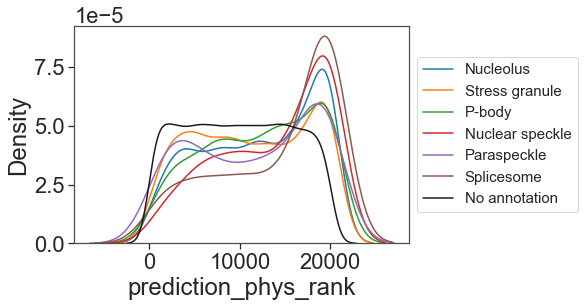

In [238]:
COND_score_EF_dict = dict(zip(predictions['Entry'], predictions[score_column]))

MLO_annot = pd.read_excel('Data/Lit_condensate_types/phasepdbv2_1_mlolt_mloht.xlsx')
MLO_annot_human = MLO_annot[MLO_annot['organism'] == 'Homo sapiens']
MLO_annot_human = MLO_annot_human[MLO_annot_human['entry'] != '_']
MLO_annot_human = MLO_annot_human[MLO_annot_human['entry'].isin(predictions['Entry']) == True]
MLO_annot_human['ID'] = MLO_annot_human['entry'] + MLO_annot_human['MLO']
MLO_annot_human = MLO_annot_human.drop_duplicates(subset = 'ID')
MLO_annot_human['COND_score'] = MLO_annot_human['entry'].map(COND_score_EF_dict)
print(MLO_annot_human.shape[0])

no_annot = predictions['Entry'][predictions['Entry'].isin(MLO_annot_human['entry']) == False]
MLOs = ['Nucleolus', 'Stress granule', 'P-body', 'Nuclear speckle', 'Paraspeckle',
        'Splicesome', 'PML nuclear body', 'Cajal body']
MLOs = ['Nucleolus', 'Stress granule', 'P-body', 'Nuclear speckle', 'Paraspeckle',
        'Splicesome']
for m in range(len(MLOs)):
    predictions[str(MLOs[m])] = np.where(predictions['Entry'].isin(MLO_annot_human['entry'][MLO_annot_human['MLO'] == MLOs[m]]),
                                True, False)
predictions['No annotation'] =  np.where(predictions['Entry'].isin(no_annot), True, False)

predictions['prediction_phys_rank'] = predictions['prediction_phys2'].rank()
score_column = 'prediction_phys_rank'
palette = itertools.cycle(sns.color_palette('tab10'))
for m in range(0, len(MLOs)):
    sns.distplot(predictions[score_column][predictions[MLOs[m]] == True], label = MLOs[m],
                 hist = False, color = next(palette))
sns.distplot(predictions[score_column][predictions['No annotation'] == True],
             hist = False, label = 'No annotation', color = 'k')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 15)
plt.savefig('Plots/scores_across_MLOs.pdf')

#First, note that performance is good with majority captured
#Second, note that no clear bias between the MLO types

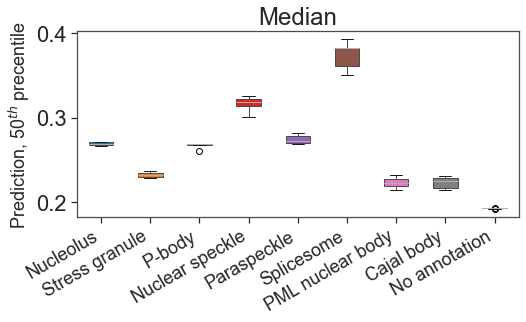

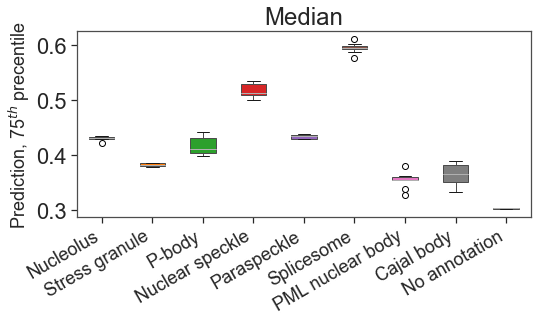

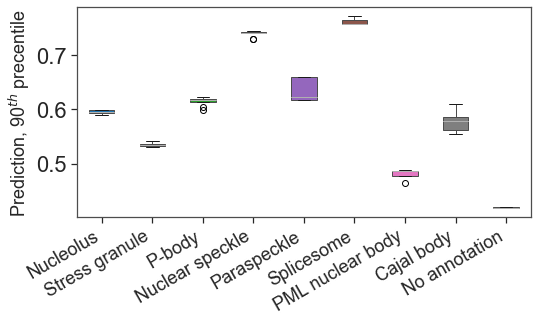

In [220]:
MLOs_all = MLOs + ['No annotation']
N = 10

percentile = 50; ps = np.zeros((N, len(MLOs_all)))
for m in range(len(MLOs_all)):
    values = []
    for t in range(0, N):
        v_temp = np.percentile(predictions['prediction_phys'][predictions[MLOs_all[m]] == True].sample(frac = 0.9),
                percentile)
        values.append(v_temp)
    ps[:, m] = values
ps[:, -1] = values

df = pd.DataFrame(ps, columns = MLOs_all)
# Get the colors from the tab10 palette
colors = sns.color_palette('tab10', n_colors=len(df.columns))

# Create a boxplot for each column
bp = df.boxplot(figsize=(8, 5), grid=False, patch_artist=True)

# Set colors for each box
for patch, color in zip(bp.patches, colors):
    patch.set_facecolor(color)
bp.set_xticklabels(df.columns)
sns.set_style("white", {"axes.edgecolor": ".3", "xtick.bottom": True, "ytick.left": True})

plt.title('Median')
plt.ylabel('Prediction, 50$^{th}$ precentile', fontsize = 18)
plt.xticks(rotation=30, ha='right', fontsize=18)
plt.tight_layout()  # Adjust layout for better visibility
plt.savefig('Plots/percentile_50.pdf')
#
plt.show()

percentile = 75; ps = np.zeros((N, len(MLOs_all)))
for m in range(len(MLOs_all)):
    values = []
    for t in range(0, N):
        v_temp = np.percentile(predictions['prediction_phys'][predictions[MLOs_all[m]] == True].sample(frac = 0.9),
                percentile)
        values.append(v_temp)
    ps[:, m] = values
ps[:, -1] = values

df = pd.DataFrame(ps, columns = MLOs_all)
# Get the colors from the tab10 palette
colors = sns.color_palette('tab10', n_colors=len(df.columns))

# Create a boxplot for each column
bp = df.boxplot(figsize=(8, 5), grid=False, patch_artist=True)

# Set colors for each box
for patch, color in zip(bp.patches, colors):
    patch.set_facecolor(color)
bp.set_xticklabels(df.columns)
sns.set_style("white", {"axes.edgecolor": ".3", "xtick.bottom": True, "ytick.left": True})

plt.title('Median')
plt.ylabel('Prediction, 75$^{th}$ precentile', fontsize = 18)
plt.xticks(rotation=30, ha='right', fontsize=18)
plt.tight_layout()  # Adjust layout for better visibility
plt.savefig('Plots/percentile_75.pdf')
plt.show()

percentile = 90; ps = np.zeros((N, len(MLOs_all)))
for m in range(len(MLOs_all)):
    values = []
    for t in range(0, N):
        v_temp = np.percentile(predictions['prediction_phys'][predictions[MLOs_all[m]] == True].sample(frac = 0.9),
                percentile)
        values.append(v_temp)
    ps[:, m] = values
ps[:, -1] = values

df = pd.DataFrame(ps, columns = MLOs_all)
# Get the colors from the tab10 palette
colors = sns.color_palette('tab10', n_colors=len(df.columns))

# Create a boxplot for each column
bp = df.boxplot(figsize=(8, 5), grid=False, patch_artist=True)

# Set colors for each box
for patch, color in zip(bp.patches, colors):
    patch.set_facecolor(color)
bp.set_xticklabels(df.columns)
sns.set_style("white", {"axes.edgecolor": ".3", "xtick.bottom": True, "ytick.left": True})

plt.ylabel('Prediction, 90$^{th}$ precentile', fontsize = 18)
plt.xticks(rotation=30, ha='right', fontsize=18)
plt.tight_layout()  # Adjust layout for better visibility
plt.savefig('Plots/percentile_90.pdf')
plt.show()